In [253]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# Set device

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Constants

INPUT_SIZE = 100
OUTPUT_SIZE = 10
LIST_OF_MIDDLE_SIZES = [100, 200, 300, 400, 500]
MAX_DIMENSION = LIST_OF_MIDDLE_SIZES[-1]*2

EPOCHS = 100
BATCH_SIZE = 128

REG_COEFF = 0.0001

Using GPU


In [254]:
class TeacherNetwork(nn.Module):
    def __init__(self, input_dimension, output_dimension, number_of_middle_neurons):
        super().__init__()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.number_of_middle_neurons = number_of_middle_neurons

        self.first_transfer = nn.Linear(self.input_dimension, self.number_of_middle_neurons)
        self.second_transfer = nn.Linear(self.number_of_middle_neurons, self.output_dimension)

    def forward(self, x):
        x = torch.relu(self.first_transfer(x))
        x = self.second_transfer(x)
        return x


In [255]:
class Phi3Network(nn.Module):
    def __init__(self, input_dimension, output_dimension, max_number_of_hidden_neurons):
        super().__init__()
    
        self.input_dim = input_dimension
        self.hidden_dim_1 = max_number_of_hidden_neurons
        self.hidden_dim_2 = max_number_of_hidden_neurons
        self.output_dim = output_dimension
    
        self.varphi1 = nn.Parameter(torch.empty(self.hidden_dim_1, self.input_dim), requires_grad=True)
        self.varphi2 = nn.Parameter(torch.empty(self.hidden_dim_2, self.hidden_dim_1), requires_grad=True)
        self.varphi3 = nn.Parameter(torch.empty(self.output_dim, self.hidden_dim_1), requires_grad=True)
    
        self.l1_diag = nn.Parameter(torch.empty(self.input_dim), requires_grad=True)
        self.l2_diag = nn.Parameter(torch.empty(self.hidden_dim_1), requires_grad=True)
        self.l3_diag = nn.Parameter(torch.empty(self.hidden_dim_2), requires_grad=True)
        self.l4_diag = nn.Parameter(torch.empty(self.output_dim), requires_grad=True)
    
        self.activation = nn.ReLU()
    
        nn.init.xavier_uniform_(self.varphi1)
        nn.init.xavier_uniform_(self.varphi2)
        nn.init.xavier_uniform_(self.varphi3)
    
        with torch.no_grad():
            self.l1_diag.fill_(0.)
            self.l2_diag.fill_(0.)
            self.l3_diag.fill_(0.)
            self.l4_diag.fill_(1.)

    def count_active_nodes(self, threshold):
        return torch.sum(self.l1_diag > threshold).item() + \
               torch.sum(self.l2_diag > threshold).item() + \
               torch.sum(self.l3_diag > threshold).item()
    
    def trim_inactive_nodes(self, threshold):
        self.l1_diag.data[self.l1_diag < threshold] = 0.
        self.l2_diag.data[self.l2_diag < threshold] = 0.
        self.l3_diag.data[self.l3_diag < threshold] = 0.
    
    def forward(self, x):
        l1 = torch.diag(self.l1_diag)
        l2 = torch.diag(self.l2_diag)
        l3 = torch.diag(self.l3_diag)
        l4 = torch.diag(self.l4_diag)
    
        W_21 = torch.mm(self.varphi1, l1) - torch.mm(l2, self.varphi1)
        W_32 = torch.mm(self.varphi2, l2) - torch.mm(l3, self.varphi2)
        W_43 = torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3)
        W_31 = torch.mm(
            torch.mm(l3, self.varphi2) - torch.mm(self.varphi2, l2),
            self.varphi1
        )
        W_42 = torch.mm(
            torch.mm(l4, self.varphi3) - torch.mm(self.varphi3, l3),
            self.varphi2
        )
        W_41 = torch.mm(
            torch.mm(
                torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3),
                self.varphi2
            ),
            self.varphi1
        )

        y = torch.mm(W_41, x.t()) + \
            torch.mm(W_42, self.activation(torch.mm(W_31, x.t()))) + \
            torch.mm(W_43, self.activation(torch.mm(W_32, self.activation(torch.mm(W_21, x.t())))) + self.activation(torch.mm(W_31, x.t())))
        
        return y.t()

In [256]:
# Generate list of techer networks

teacher_networks = [TeacherNetwork(INPUT_SIZE, OUTPUT_SIZE, middle_size) for middle_size in LIST_OF_MIDDLE_SIZES]

for teacher_network in teacher_networks:
    teacher_network.to(device)

In [257]:
# Generate random input vectors with entries in [-1,1]

number_of_samples = 10000
input_vectors = torch.rand((number_of_samples, INPUT_SIZE), device=device)*2-1

# Print examples

print('Examples of input vector:\n', input_vectors[0])

Examples of input vector:
 tensor([ 0.3934, -0.6535, -0.5399, -0.1215,  0.2419,  0.2091,  0.8790, -0.8994,
        -0.9709,  0.4329,  0.4061,  0.9235,  0.1226, -0.2671, -0.3352, -0.7379,
         0.0575,  0.7850, -0.0027, -0.2858,  0.3961,  0.8437, -0.3321, -0.0020,
         0.8221, -0.0628, -0.5916,  0.0979, -0.6187, -0.1930, -0.2336, -0.9143,
        -0.4100,  0.9814,  0.0646, -0.2767, -0.3276,  0.5301,  0.6327,  0.4108,
        -0.3082,  0.4275,  0.0854,  0.9198,  0.7831,  0.3005, -0.9167,  0.0031,
         0.3580, -0.9995,  0.1151,  0.9840,  0.3381, -0.5489, -0.2835,  0.5836,
        -0.4235, -0.0027,  0.5205,  0.9095,  0.3691, -0.3143,  0.7294,  0.1252,
         0.2633,  0.8979, -0.0158,  0.6673, -0.1502,  0.7281,  0.2214,  0.8916,
         0.9356, -0.4226, -0.6235, -0.4795, -0.8425,  0.1770,  0.4303,  0.4385,
         0.7861, -0.5825, -0.7700,  0.5841,  0.7178,  0.2234, -0.0411, -0.4185,
         0.9465,  0.2041, -0.6370, -0.4448,  0.3512, -0.5366, -0.0303, -0.8864,
         0.18

In [258]:
# Generate outputs for each teacher network

with torch.no_grad():
    teacher_outputs = [teacher_network(input_vectors) for teacher_network in teacher_networks]

print('Examples of outputs for each teacher network:\n')

for i in range(2):
    print(f'Teacher {i+1}:')
    for j in range(3):
        print(teacher_outputs[i][j])
    print()


Examples of outputs for each teacher network:

Teacher 1:
tensor([-0.2225, -0.1663,  0.3151,  0.0353, -0.0923,  0.1565,  0.1426,  0.0027,
         0.0902, -0.0403], device='cuda:0')
tensor([-0.2002, -0.0777,  0.0605, -0.0327, -0.0784,  0.0118,  0.1325, -0.1400,
         0.1577,  0.0116], device='cuda:0')
tensor([-0.2178, -0.0771,  0.0717, -0.0968, -0.0524,  0.1258, -0.0331,  0.0309,
         0.2203, -0.3299], device='cuda:0')

Teacher 2:
tensor([-0.0532, -0.1279,  0.0430,  0.0516, -0.1284,  0.1948, -0.0209,  0.1686,
         0.1063, -0.1273], device='cuda:0')
tensor([-0.0943,  0.0840,  0.1521,  0.0407,  0.0048,  0.0473, -0.0305,  0.0252,
         0.2313,  0.0538], device='cuda:0')
tensor([ 0.0206,  0.0451, -0.0957,  0.1448,  0.0693,  0.0776, -0.0372, -0.1225,
         0.2138,  0.0685], device='cuda:0')



In [259]:
# Create list of teacher datasets

teacher_datasets = [list(zip(input_vectors, teacher_output)) for teacher_output in teacher_outputs]

# Create list of teacher dataloaders

teacher_dataloaders = [DataLoader(teacher_dataset, batch_size=BATCH_SIZE, shuffle=True) for teacher_dataset in teacher_datasets]

In [260]:
# Train Phi3 networks without regularization

trained_phi3_networks = []
network_losses = []

for i, teacher_dataloader in enumerate(teacher_dataloaders):
    phi3_network = Phi3Network(INPUT_SIZE, OUTPUT_SIZE, MAX_DIMENSION)
    phi3_network.to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(phi3_network.parameters(), lr=0.001)
    losses = []

    for epoch in tqdm(range(EPOCHS), desc=f'Teacher {i+1}'):
        total_loss = 0
        for inputs, labels in teacher_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = phi3_network(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(total_loss)
        

    network_losses.append(losses)
    
    trained_phi3_networks.append(phi3_network)

Teacher 1:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 2:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 3:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 4:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 5:   0%|          | 0/100 [00:00<?, ?it/s]

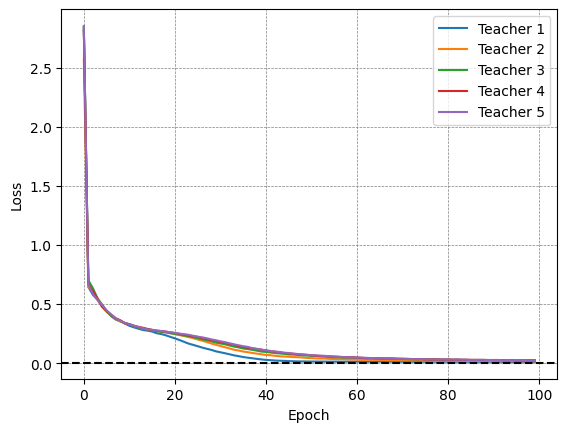

In [261]:
# Make loss plots

for i, losses in enumerate(network_losses):
    plt.plot(losses, label=f'Teacher {i+1}')

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.show()

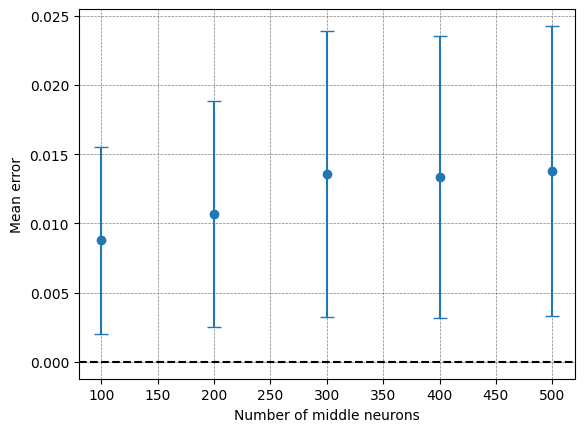

In [262]:
# Make mean error graph

mean_errors = []
std_devs = []

for i, teacher_dataset in enumerate(teacher_datasets):
    with torch.no_grad():
        mean_error = torch.mean(torch.abs(teacher_outputs[i] - trained_phi3_networks[i](input_vectors)).detach()).item()
        mean_errors.append(mean_error)
        std_dev = torch.std(torch.abs(teacher_outputs[i] - trained_phi3_networks[i](input_vectors)).detach()).item()
        std_devs.append(std_dev)

plt.errorbar(LIST_OF_MIDDLE_SIZES, mean_errors, yerr=std_devs, fmt='o', capsize=5)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Number of middle neurons')

plt.ylabel('Mean error')

plt.show()

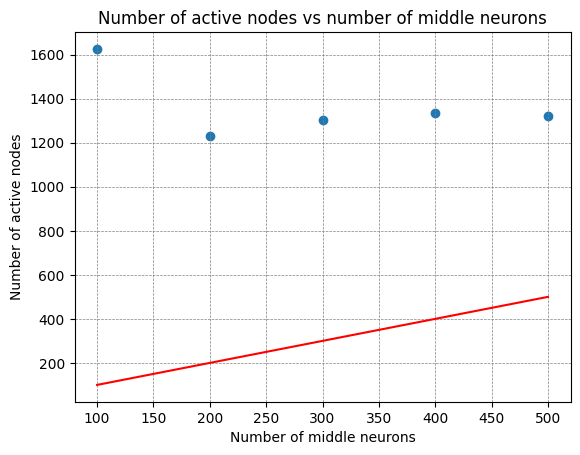

In [263]:
# Plot of active nodes

active_nodes_list = [phi3_network.count_active_nodes(0.01) for phi3_network in trained_phi3_networks]

plt.scatter(LIST_OF_MIDDLE_SIZES, active_nodes_list)

#Plot diagonal

plt.plot(LIST_OF_MIDDLE_SIZES, LIST_OF_MIDDLE_SIZES, color='red')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.title('Number of active nodes vs number of middle neurons')

plt.xlabel('Number of middle neurons')

plt.ylabel('Number of active nodes')

plt.show()



In [264]:
# Train Phi3 networks with regularization

trained_phi3_networks_r = []
network_losses_r = []

for i, teacher_dataloader in enumerate(teacher_dataloaders):
    phi3_network = Phi3Network(INPUT_SIZE, OUTPUT_SIZE, MAX_DIMENSION)
    phi3_network.to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(phi3_network.parameters(), lr=0.001)
    losses = []

    for epoch in tqdm(range(EPOCHS), desc=f'Teacher {i+1}'):
        total_loss = 0
        for inputs, labels in teacher_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = phi3_network(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Lasso regularization
            loss += REG_COEFF * torch.sum(torch.abs(phi3_network.l1_diag)) + \
                    REG_COEFF * torch.sum(torch.abs(phi3_network.l2_diag)) + \
                    REG_COEFF * torch.sum(torch.abs(phi3_network.l3_diag))
            
            loss.backward()
            optimizer.step()

        losses.append(total_loss)
        

    network_losses_r.append(losses)
    
    trained_phi3_networks_r.append(phi3_network)

Teacher 1:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 2:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 3:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 4:   0%|          | 0/100 [00:00<?, ?it/s]

Teacher 5:   0%|          | 0/100 [00:00<?, ?it/s]

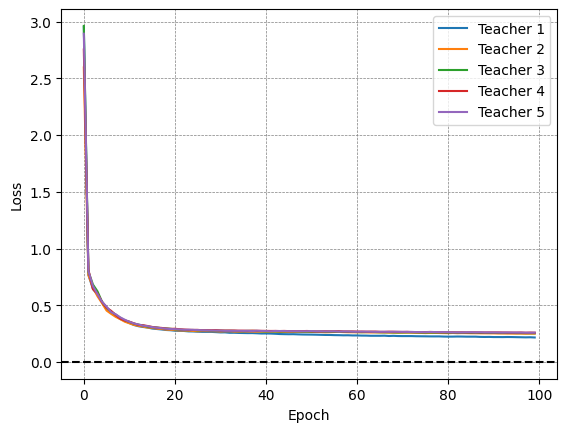

In [265]:
# Make loss plots

for i, losses in enumerate(network_losses_r):
    plt.plot(losses, label=f'Teacher {i+1}')

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.show()

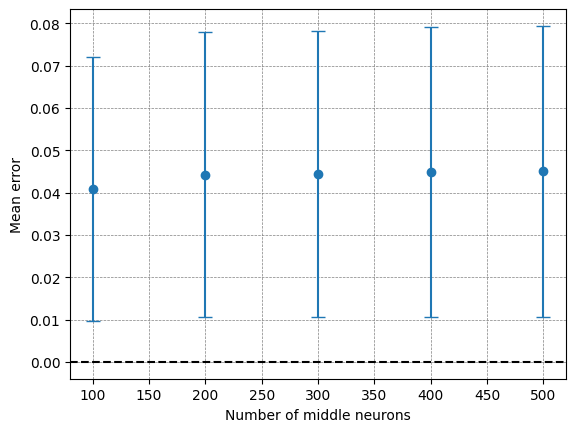

In [266]:
# Make mean error graph

mean_errors_r = []
std_devs_r = []

for i, teacher_dataset in enumerate(teacher_datasets):
    with torch.no_grad():
        mean_error = torch.mean(torch.abs(teacher_outputs[i] - trained_phi3_networks_r[i](input_vectors)).detach()).item()
        mean_errors_r.append(mean_error)
        std_dev = torch.std(torch.abs(teacher_outputs[i] - trained_phi3_networks_r[i](input_vectors)).detach()).item()
        std_devs_r.append(std_dev)

plt.errorbar(LIST_OF_MIDDLE_SIZES, mean_errors_r, yerr=std_devs_r, fmt='o', capsize=5)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Number of middle neurons')

plt.ylabel('Mean error')

plt.show()



Number of active nodes for teacher 1: 4
Number of active nodes for teacher 2: 8
Number of active nodes for teacher 3: 5
Number of active nodes for teacher 4: 10
Number of active nodes for teacher 5: 8


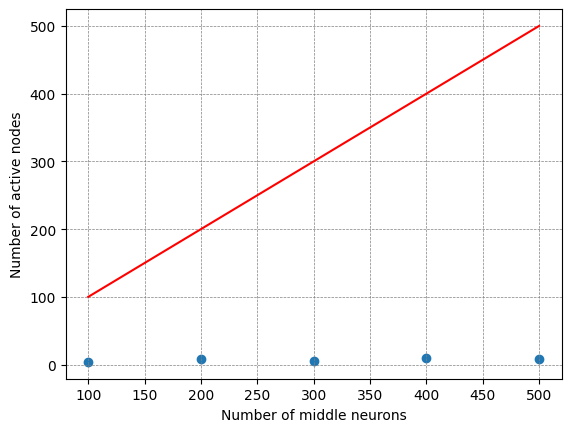

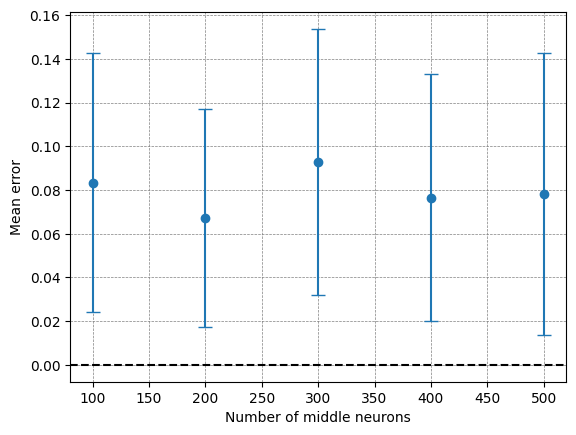

In [277]:
# Trimming and then plotting active nodes and error

TRIMMING_THRESHOLD = 0.00001

active_nodes_list = [phi3_network.count_active_nodes(TRIMMING_THRESHOLD) for phi3_network in trained_phi3_networks_r]

for i, phi3_network in enumerate(trained_phi3_networks):
    print(f'Number of active nodes for teacher {i+1}: {active_nodes_list[i]}')

plt.scatter(LIST_OF_MIDDLE_SIZES, active_nodes_list)

#Plot diagonal

plt.plot(LIST_OF_MIDDLE_SIZES, LIST_OF_MIDDLE_SIZES, color='red')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Number of middle neurons')

plt.ylabel('Number of active nodes')

plt.show()

# Make mean error graph

mean_errors = []
std_devs = []

for i, teacher_dataset in enumerate(teacher_datasets):
    trained_phi3_networks_r[i].trim_inactive_nodes(TRIMMING_THRESHOLD)
    with torch.no_grad():
        mean_error = torch.mean(torch.abs(teacher_outputs[i] - trained_phi3_networks_r[i](input_vectors)).detach()).item()
        mean_errors.append(mean_error)
        std_dev = torch.std(torch.abs(teacher_outputs[i] - trained_phi3_networks_r[i](input_vectors)).detach()).item()
        std_devs.append(std_dev)

plt.errorbar(LIST_OF_MIDDLE_SIZES, mean_errors, yerr=std_devs, fmt='o', capsize=5)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Number of middle neurons')

plt.ylabel('Mean error')

plt.show()




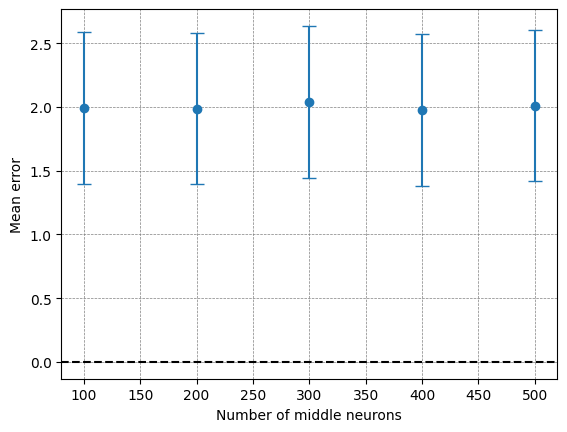

In [273]:
# Make graf of random guessing error

mean_errors = []
std_devs = []

for i, teacher_dataset in enumerate(teacher_datasets):
    with torch.no_grad():
        mean_error = torch.mean(torch.abs(teacher_outputs[i] - torch.rand((number_of_samples, OUTPUT_SIZE), device=device)*2-1)).item()
        std_dev = torch.std(torch.abs(teacher_outputs[i] - torch.rand((number_of_samples, OUTPUT_SIZE), device=device)*2-1)).item()
        mean_errors.append(mean_error)
        std_devs.append(std_dev)

plt.errorbar(LIST_OF_MIDDLE_SIZES, mean_errors, yerr=std_devs, fmt='o', capsize=5)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.xlabel('Number of middle neurons')

plt.ylabel('Mean error')

plt.show()
